In [1]:
import pandas as pd
from math import sqrt
import seaborn as sns
import matplotlib_venn as pltv
import matplotlib.pyplot as plt

from ProjectTools import OpenBeds

In [2]:
dry = True

def dropColumns(df):
    redundant_columns = ["modification_type", "percentMeth", "strand", "modified_reads", "unmodified_reads"]
    return df.drop(columns=redundant_columns, errors="ignore")    

if dry == True:
    wgbs_bed_path = './test_data/ENCSR893RHD_modifications_mm39_sub.bed'
    tab_bed_path = './test_data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov_sub.bed'

    nano_2mod_path = './test_data/prom_R10.4.1_E8.2_WGS_brain_DH_5mC_nonAggregated_sub.bedMethyl'
    nano_3mod_path = './test_data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods_sub.bed'
    
    nano_mc_df, nano_hmc_df = OpenBeds.get_nanopore_threeMod(nano_3mod_path)
    nano_mc_df = dropColumns(OpenBeds.get_nanopore_twoMod(nano_2mod_path)) # easier just to overwrite nano_mc
    wgbs_df = dropColumns(OpenBeds.get_wgbs(wgbs_bed_path))
    tab_df = dropColumns(OpenBeds.get_tab(tab_bed_path))

    nano_hmc_df = dropColumns(nano_hmc_df)

else:
    wgbs_bed_path = './data/ENCSR893RHD_modifications_mm39.bed'
    tab_bed_path = './data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov'
    nano_2mod_path = './data/prom_R10.4.1_E8.2_WGS_brain_DH_5mC_nonAggregated.bedMethyl'
    nano_3mod_path = './data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods.bed'

    wgbs_df = dropColumns(OpenBeds.get_wgbs(wgbs_bed_path))
    tab_df = dropColumns(OpenBeds.get_tab(tab_bed_path))
    nano_mc_df, nano_hmc_df = OpenBeds.get_nanopore_threeMod(nano_3mod_path)
    nano_mc_df = dropColumns(OpenBeds.get_nanopore_twoMod(nano_2mod_path))

    nano_hmc_df = dropColumns(nano_hmc_df)

def filterDepth(df):
    average = df["readCount"].mean()
    df = df[df["readCount"].ge(10)]
    df = df[df["readCount"].le(average + 3*sqrt(average))]
    return df

def filterMergeNano(nano_mc, nano_hmc):
    filtered_mc = filterDepth(nano_mc).drop(columns="method")
    filtered_hmc = filterDepth(nano_hmc).drop(columns="method")
    
    on_list = ["chromosome", "chromStart", "chromEnd"]
    merged = pd.merge(filtered_mc, filtered_hmc, "inner", on_list, suffixes=["_5mC", "_5hmC"])

    merged["method"] = "Nanopore"
    merged["readCount"] = merged[["readCount_5mC", "readCount_5hmC"]].mean(axis=1)
    
    return merged.drop(columns=["readCount_5mC", "readCount_5hmC"])

def calculateIntersect(l, r, out):
    intersect = pd.merge(l, r, "inner", ["chromosome", "chromStart", "chromEnd"])
    excluding = pd.merge(intersect, out, "inner", ["chromosome", "chromStart", "chromEnd"])
    return len(intersect) - len(excluding) 

nano_n_wgbs = calculateIntersect(filterMergeNano(nano_hmc_df, nano_mc_df),
                                   filterDepth(wgbs_df), 
                                   filterDepth(tab_df))
nano_n_tab = calculateIntersect(filterMergeNano(nano_hmc_df, nano_mc_df), 
                                 filterDepth(tab_df),
                                 filterDepth(wgbs_df))
wgbs_n_tab = calculateIntersect(filterDepth(wgbs_df), 
                                 filterDepth(tab_df), 
                                 filterMergeNano(nano_hmc_df, nano_mc_df))

all_overlap = len(
    pd.merge(
        pd.merge(filterMergeNano(nano_hmc_df, nano_mc_df), filterDepth(wgbs_df),
        "inner", ["chromosome", "chromStart", "chromEnd"]), 
    filterDepth(tab_df), "inner", ["chromosome", "chromStart", "chromEnd"]))

just_nano = len(filterMergeNano(nano_hmc_df, nano_mc_df)) - (nano_n_wgbs + nano_n_tab + all_overlap)
just_wgbs = len(filterDepth(wgbs_df)) - (wgbs_n_tab + nano_n_wgbs + all_overlap)
just_tab = len(filterDepth(tab_df)) - (wgbs_n_tab + nano_n_tab + all_overlap)

In [4]:
from pybedtools import BedTool

def findTypeIntersects(mod_bed, ref_features_bed, intergenic_bed):
    features_df = BedTool.intersect(mod_bed, ref_features_bed, wb=True).to_dataframe(
        names=["chromosome", "chromStart", "chromEnd", "readCount", "method", "dup1", "dup2", "dup3", "feature_type"])
    features_df.loc[features_df["feature_type"].str.contains("CpG"), "feature_type"] = "CGI"
    intergenic_df = BedTool.intersect(mod_bed, intergenic_bed, wb=True).to_dataframe(
        names=["chromosome", "chromStart", "chromEnd",  "readCount", "method", "dup1", "dup2", "dup3", "feature_type"])

    return pd.concat([features_df, intergenic_df]).reset_index(drop=True).drop(columns=["dup1", "dup2", "dup3"])

In [5]:

ref_features = BedTool('./feature_references/fig1_features.bed')
intergenic_bed = BedTool('./feature_references/fig1_features/mm39_intergenic_noID.bed')

def generateModbed(mod_df1, mod_df2):
    filtered_df1 = filterDepth(mod_df1)
    filtered_df2 = filterDepth(mod_df2)
    concat_dfs = pd.concat([filtered_df1, filtered_df2])

    concat_dfs.loc[concat_dfs["method"].str.contains("Nanopore"), "method"] = "Nanopore"
    return BedTool.from_dataframe(concat_dfs)

In [6]:
def generateGenomewide(mod_df):
    dummy_df = mod_df.copy()
    dummy_df["feature_type"] = "Genome-wide"

    dummy_df.loc[dummy_df["method"].str.contains("Nanopore"), "method"] = "Nanopore"
    return dummy_df

def includeGenomewide(intersects_df, mod_df1, mod_df2):
    return pd.concat([intersects_df, generateGenomewide(mod_df1), generateGenomewide(mod_df2)]).reset_index(drop=True)

def calculateFilteredGenomeMedian(mod_df):
    return filterDepth(mod_df)["readCount"].median()

In [7]:
mc_allFeature_df = includeGenomewide(findTypeIntersects(generateModbed(nano_mc_df, wgbs_df), ref_features, intergenic_bed),
                                          filterDepth(nano_mc_df), filterDepth(wgbs_df))

hmc_allFeature_df = includeGenomewide(findTypeIntersects(generateModbed(nano_hmc_df, tab_df), ref_features, intergenic_bed),
                                          filterDepth(nano_hmc_df), filterDepth(tab_df))

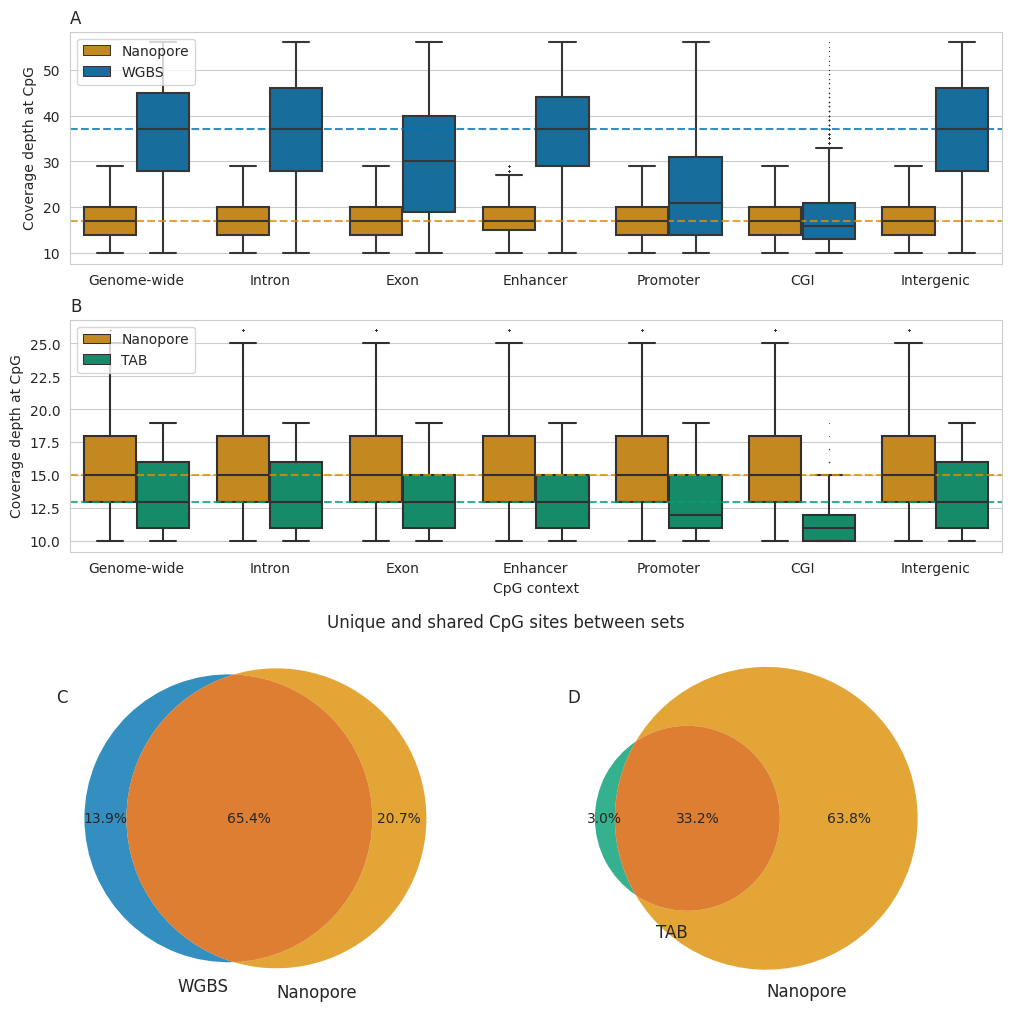

In [8]:
import matplotlib.gridspec as gridspec

sns.set_style("whitegrid")

fig0 = plt.figure(figsize=(10,10))
gs0 = gridspec.GridSpec(2, 1, fig0, height_ratios=[3,2])

fig1 = fig0.add_subfigure(gs0[0, :])
gs1 = gridspec.GridSpec(2, 1, fig1)

ax1 = fig1.add_subplot(gs1[0, :])
sns.boxplot(mc_allFeature_df, x="feature_type", y="readCount", hue="method", ax=ax1, palette={
    "Nanopore" : sns.color_palette("colorblind", 4)[1], 
    "WGBS" : sns.color_palette("colorblind", 4)[0]}, 
    flierprops={
    "marker":"x", 
    "markersize" : 0.1},
    order=["Genome-wide", "Intron", "Exon", "Enhancer", "Promoter", "CGI", "Intergenic"])
sns.move_legend(ax1, "upper left", title=None)
ax1.tick_params("x")
ax1.set(xlabel=None, ylabel="Coverage depth at CpG")
ax1.set_title("A", loc="left")
ax1.axhline(y=calculateFilteredGenomeMedian(nano_mc_df), alpha=0.8, color=sns.color_palette("colorblind", 4)[1], linestyle="--")
ax1.axhline(y=calculateFilteredGenomeMedian(wgbs_df), alpha=0.8, color=sns.color_palette("colorblind", 4)[0], linestyle="--")


ax2 = fig1.add_subplot(gs1[1, :], sharex=ax1)
sns.boxplot(hmc_allFeature_df, x="feature_type", y="readCount", hue="method", ax=ax2, palette={
    "Nanopore" : sns.color_palette("colorblind", 4)[1], 
    "TAB" : sns.color_palette("colorblind", 4)[2]}, 
    flierprops={
        "marker":"x", 
        "markersize" : 0.1},
        order=["Genome-wide", "Intron", "Exon", "Enhancer", "Promoter", "CGI", "Intergenic"])
sns.move_legend(ax2, "upper left", title=None)
ax2.set(xlabel="CpG context", ylabel="Coverage depth at CpG")
ax2.tick_params("x")
ax2.set_title("B", loc="left")
ax2.axhline(y=calculateFilteredGenomeMedian(nano_hmc_df), alpha=0.8, color=sns.color_palette("colorblind", 4)[1], linestyle="--")
ax2.axhline(y=calculateFilteredGenomeMedian(tab_df), alpha=0.8, color=sns.color_palette("colorblind", 4)[2], linestyle="--")

fig2 = fig0.add_subfigure(gs0[1,:])
gs2 = gridspec.GridSpec(1, 2, fig2)

ax3 = fig2.add_subplot(gs2[0, 0])
v1 = pltv.venn2((just_wgbs, just_nano, nano_n_wgbs), set_labels=["WGBS", "Nanopore"], alpha=0.8, ax=ax3)
v1.get_label_by_id("10").set_text("{:.1%}".format((just_wgbs/(just_wgbs + just_nano + nano_n_wgbs))))
v1.get_patch_by_id("10").set_facecolor(sns.color_palette("colorblind", 4)[0])
v1.get_label_by_id("01").set_text("{:.1%}".format((just_nano/(just_wgbs + just_nano + nano_n_wgbs))))
v1.get_patch_by_id("01").set_facecolor(sns.color_palette("colorblind", 4)[1])
v1.get_label_by_id("11").set_text("{:.1%}".format((nano_n_wgbs/(just_wgbs + just_nano + nano_n_wgbs))))
v1.get_patch_by_id("11").set_facecolor(sns.color_palette("colorblind", 4)[3])
ax3.set_title("C", loc="left", y=0.8)

ax4 = fig2.add_subplot(gs2[0, 1])
v2 = pltv.venn2((just_tab, just_nano, nano_n_tab), set_labels=["TAB", "Nanopore"], alpha=0.8, ax=ax4)
v2.get_label_by_id("10").set_text("{:.1%}".format((just_tab/(just_tab + just_nano + nano_n_tab))))
v2.get_patch_by_id("10").set_facecolor(sns.color_palette("colorblind", 4)[2])
v2.get_label_by_id("01").set_text("{:.1%}".format((just_nano/(just_tab + just_nano + nano_n_tab))))
v2.get_patch_by_id("01").set_facecolor(sns.color_palette("colorblind", 4)[1])
v2.get_label_by_id("11").set_text("{:.1%}".format((nano_n_tab/(just_tab + just_nano + nano_n_tab))))
v2.get_patch_by_id("11").set_facecolor(sns.color_palette("colorblind", 4)[3])
ax4.set_title("D", loc="left", y=0.8)
fig2.suptitle("Unique and shared CpG sites between sets")

fig0.set_constrained_layout(True)
fig0.show()

In [8]:
filterDepth(nano_mc_df)["readCount"].median(), filterDepth(nano_hmc_df)["readCount"].median(), filterDepth(wgbs_df)["readCount"].median(), filterDepth(tab_df)["readCount"].median()

(17.0, 15.0, 34.0, 13.0)